<a href="https://colab.research.google.com/github/HenryLimaa/JPasEDR-Gaia/blob/master/Abordagens_de_Aprendizado_de_M%C3%A1quina_N%C3%A3o_Supervisionado_para_Identifica%C3%A7%C3%A3o_de_Objetos_Raros_no_Projeto_J_PAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Abordagens de Aprendizado de Máquina Não-Supervisionado para Identificação de Objetos Raros no Projeto J-PAS**

### **Capítulo 1: Introdução à Astronomia de Dados Massivos e o Paradigma J-PAS**

A astronomia contemporânea atravessa uma fase de transformação paradigmática, frequentemente descrita como a era do "Big Data" astronômico. A transição de observações focadas em objetos individuais para levantamentos sistemáticos do céu (surveys) gerou um volume de dados que excede a capacidade humana de análise manual (FRAIX-BURNET et al., 2021). Neste contexto, o projeto Javalambre-Physics of the Accelerated Universe Astrophysical Survey (J-PAS) destaca-se como uma iniciativa de fronteira. Equipado com um sistema óptico singular composto por 56 filtros de banda estreita, o J-PAS oferece uma resolução espectral sem precedentes para um survey fotométrico, efetivamente operando como uma "máquina de redshift" capaz de mapear o Universo em três dimensões com alta precisão (BENÍTEZ et al., 2014; BONOLI et al., 2022).

A riqueza informacional contida nos dados do J-PAS, especificamente nas Distribuições Espectrais de Energia (SEDs) de milhões de objetos, apresenta tanto uma oportunidade quanto um desafio computacional. Enquanto a classificação de objetos comuns (estrelas da sequência principal, galáxias elípticas e espirais típicas) pode ser realizada com alta eficiência por métodos supervisionados clássicos, a detecção de objetos raros ou anômalos — aqueles que desafiam as categorias preestabelecidas — exige uma abordagem distinta (BALL; BRUNNER, 2010). É neste nicho que o Aprendizado de Máquina Não-Supervisionado (UML) demonstra seu valor inestimável.

A presente tese de doutorado propõe a utilização de Redes Neurais Artificiais, especificamente Mapas Auto-Organizáveis (SOM - Self-Organizing Maps), para explorar a topologia dos dados do J-PAS sem o viés imposto por rótulos de treinamento prévios. O objetivo central não é apenas classificar o conhecido, mas descobrir o desconhecido: objetos com propriedades físicas extremas, como galáxias com linhas de emissão anômalas, quasares em configurações exóticas ou classes estelares raras, que residem nas "caudas" das distribuições estatísticas. Diferentemente de abordagens tradicionais que descartam outliers como ruído instrumental ou contaminação, esta pesquisa adota a premissa fundamental de que os outliers constituem a peça mais valiosa do conjunto de dados, representando o potencial de nova física ou fenômenos astrofísicos ainda não catalogados (BARON; POZNANSKI, 2017).

Para viabilizar esta investigação, é imperativo estabelecer um pipeline de processamento de dados rigoroso e cientificamente robusto. Este relatório detalha a implementação computacional desse pipeline, desde a ingestão dos dados brutos e o pré-processamento das magnitudes e fluxos, até a modelagem neural e a geração de catálogos locais. A metodologia aqui descrita prioriza a integridade dos dados, mantendo todas as observações, inclusive aquelas com baixa relação sinal-ruído (SNR), para garantir que nenhuma descoberta potencial seja descartada prematuramente.

### **Capítulo 2: Engenharia de Dados e Pré-processamento Fotométrico**

#### **2.1 Arquitetura Computacional e Bibliotecas**

O desenvolvimento de algoritmos para análise de dados astronômicos em larga escala requer um ambiente computacional otimizado para operações vetoriais e manipulação matricial. A escolha da linguagem Python, apoiada por bibliotecas científicas consolidadas, fornece a infraestrutura necessária para lidar com a complexidade dos dados do J-PAS.

A importação das bibliotecas constitui o alicerce do código. Utilizamos pandas para a estruturação tabular dos dados e numpy para a computação numérica de alta performance, essencial para o cálculo de erros e métricas de distância em espaços multidimensionais. A visualização dos dados, etapa crítica para o diagnóstico exploratório e a validação dos modelos, é suportada por matplotlib e seaborn. No núcleo da modelagem de aprendizado de máquina, empregamos a biblioteca minisom (VETTIGLI, 2019) para a implementação dos Mapas Auto-Organizáveis, juntamente com scikit-learn e scipy para tarefas auxiliares de redução de dimensionalidade (PCA) e agrupamento hierárquico. A configuração do ambiente inclui também o gerenciamento de arquivos e alertas do sistema, garantindo uma execução fluida e reprodutível.

In [1]:
# Instalação da biblioteca MiniSom, caso não esteja presente no ambiente
!pip install minisom

# Manipulação de Sistema e Arquivos
import os
import threading
import random
import json
from datetime import datetime
import pickle
import warnings
from tqdm import tqdm
import time

# Processamento de Dados e Matemática
import pandas as pd
import numpy as np

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap

# Machine Learning e Estatística
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from minisom import MiniSom
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Configuração de Warnings para manter a saída limpa, focando nos resultados
import warnings
warnings.filterwarnings('ignore')

# Configuração de acesso ao Drive (específico para ambientes como Google Colab)
from google.colab import drive
drive.mount('/content/drive')

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.5-py3-none-any.whl size=12031 sha256=0db043f5e4bcc985d7b0d19cb82f92e538bb7b5c08f345f2281c6690e9dd3fef
  Stored in directory: /root/.cache/pip/wheels/0f/8c/a4/5b7aa56fa6ef11d536d45da775bcc5a2a1c163ff0f8f11990b
Successfully built minisom
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### **2.2 Ingestão e Diagnóstico dos Catálogos Brutos**

A etapa de ingestão de dados é o ponto onde a teoria observacional encontra a realidade dos arquivos digitais. O conjunto de dados utilizado provém do cruzamento (crossmatching) entre as observações do J-PAS (via miniJPAS) e o catálogo astrométrico Gaia (MOLINO et al., 2019; GAIA COLLABORATION et al., 2018). Esta fusão de catálogos enriquece a análise, combinando a precisão fotométrica das 56 bandas do J-PAS com a astrometria de alta precisão do Gaia.

Nesta fase, carregamos quatro conjuntos de dados distintos: magnitudes, erros de magnitude, fluxos e erros relativos de fluxo. A distinção entre magnitude e fluxo é crucial. Enquanto a magnitude é uma escala logarítmica tradicional na astronomia, o fluxo é uma medida linear da densidade de fótons recebidos. Para algoritmos de aprendizado de máquina e detecção de anomalias, o uso de fluxo é frequentemente preferível, pois evita as singularidades matemáticas associadas a objetos muito fracos ou não detectados (onde o fluxo pode ser zero ou negativo devido ao ruído de fundo, resultando em magnitudes indefinidas).

A leitura inicial dos arquivos CSV revela a dimensão do desafio: dezenas de milhares de objetos (17.378 no arquivo de magnitude e 27.032 no de fluxo), cada um contendo informações espectrais complexas comprimidas em strings de texto. A discrepância no número de objetos entre os arquivos de magnitude e fluxo sugere que o catálogo de fluxo preserva objetos que, por serem muito fracos, não puderam ter uma magnitude confiavelmente calculada, reforçando a decisão metodológica de priorizar o fluxo para a detecção de objetos raros e fracos.   



In [2]:
# Definição dos caminhos dos arquivos (ajuste conforme o ambiente local)
path_dir = '/content/drive/MyDrive/Notebook fotometrias/'

# Carregamento dos arquivos CSV em DataFrames do Pandas de forma individualizada.
# MAGNITUDE
try:
    df = pd.read_csv(os.path.join(path_dir, 'Conjunto de dados (crossmating).csv'))
    df_err = pd.read_csv(os.path.join(path_dir, 'ERR_Conjunto de dados (cros).csv'))
except FileNotFoundError:
    print("Arquivos de magnitude não encontrados. Verifique os caminhos.")
    # Criação de DataFrames vazios para evitar erros de execução se arquivos faltarem
    df = pd.DataFrame()
    df_err = pd.DataFrame()

# FLUXO
try:
    df_flux = pd.read_csv(os.path.join(path_dir, 'FLUX_APER_COR_3_0.csv'))
    df_err_flux = pd.read_csv(os.path.join(path_dir, 'FLUX_RELERR_APER_COR_3_0.csv'))
except FileNotFoundError:
    print("Arquivos de fluxo não encontrados. Verifique os caminhos.")
    df_flux = pd.DataFrame()
    df_err_flux = pd.DataFrame()

# Contar o número de Linhas (excluindo o cabeçalho) e exibir estatísticas iniciais
if not df.empty:
    numero_estrelas = len(df)
    numero_estrelas_err = len(df_err)
    print(f"O número total de estrelas (MAGNITUDE) é: {numero_estrelas}")
    print(f"O número total de estrelas (ERRO MAGNITUDE) é: {numero_estrelas_err}")

if not df_flux.empty:
    numero_estrelas_flux = len(df_flux)
    numero_estrelas_err_flux = len(df_err_flux)
    print(f"O número total de estrelas (FLUXO) é: {numero_estrelas_flux}")
    print(f"O número total de estrelas (ERRO FLUXO) é: {numero_estrelas_err_flux}")

Arquivos de magnitude não encontrados. Verifique os caminhos.
O número total de estrelas (FLUXO) é: 27032
O número total de estrelas (ERRO FLUXO) é: 27032


#### **2.3 Inspeção Visual da Estrutura de Dados**

Antes de qualquer manipulação algébrica, é mandatório realizar uma inspeção visual da estrutura interna dos DataFrames. A função head() permite visualizar as primeiras entradas e confirma uma característica crítica do formato de dados do J-PAS: o encapsulamento vetorial em strings.

As colunas MAG_APER_COR_3_0 e FLUX_APER_COR_3_0 não contêm escalares, mas sim longas cadeias de caracteres contendo os 56 valores de fotometria separados por espaços. Esta estrutura compacta é eficiente para armazenamento, mas inadequada para processamento analítico direto. A inspeção revela também a presença de metadados fundamentais como TILE_ID e NUMBER, que servirão como chaves primárias para a rastreabilidade dos objetos no catálogo final, além de dados astrométricos como paralaxe (Plx) e seu erro (e_Plx), vitais para distinguir estrelas de objetos extragalácticos (quasares e galáxias) em etapas posteriores de validação.



In [3]:
# Exibimos as primeiras Linhas do DataFrame (MAGNITUDE) para entender sua estrutura.
if not df.empty:
    print("Primeiras linhas do DataFrame (MAGNITUDE):")
    display(df.head())

# Exibimos as primeiras Linhas do DataFrame dos erros (MAGNITUDE) para entender sua estrutura.
if not df_err.empty:
    print("Primeiras linhas do DataFrame (ERRO MAGNITUDE):")
    display(df_err.head())

# Exibimos as primeiras Linhas do DataFrame (FLUXO) para entender sua estrutura.
if not df_flux.empty:
    print("Primeiras linhas do DataFrame (FLUXO):")
    display(df_flux.head())

# Exibimos as primeiras Linhas do DataFrame (ERROS FLUXO) para entender sua estrutura.
if not df_err_flux.empty:
    print("Primeiras linhas do DataFrame (ERRO FLUXO):")
    display(df_err_flux.head())

Primeiras linhas do DataFrame (FLUXO):


,TILE_ID,NUMBER,FLUX_APER_COR_3_0,Plx,e_Plx,erro_relativo_paralaxe
0,8955,46387,582.97656 601.3763 678.82666 1383.5822 2058.70...,1.2200,0.1069,8.762295
1,9654,2,45190.008 46248.64 50623.14 104671.91 150363.9...,0.5789,0.0127,2.193816
2,9654,7,9898.973 26180.986 32765.014 41903.01 41733.52...,0.0947,0.0181,19.112989
3,9654,10,8215.598 11258.105 11986.251 20894.367 26783.6...,1.2176,0.0145,1.190867
4,9654,11,298.2201 322.17673 377.74734 633.40826 931.354...,1.9435,0.0366,1.883200


Primeiras linhas do DataFrame (ERRO FLUXO):


,TILE_ID,NUMBER,FLUX_RELERR_APER_COR_3_0,Plx,e_Plx,erro_relativo_paralaxe
0,8955,46387,0.045776 0.043762 0.025101 0.013893 0.013901 0...,1.2200,0.1069,8.762295
1,9654,2,0.002365 0.002163 0.002184 0.000946 0.002373 0...,0.5789,0.0127,2.193816
2,9654,7,0.005432 0.002943 0.003006 0.001644 0.004314 0...,0.0947,0.0181,19.112989
3,9654,10,0.005947 0.004543 0.004993 0.002329 0.005363 0...,1.2176,0.0145,1.190867
4,9654,11,0.071899 0.048828 0.041199 0.018341 0.05658 0....,1.9435,0.0366,1.883200


#### **2.4 Decomposição Vetorial e Engenharia de Atributos**

A transformação dos dados brutos em um formato "analiticamente pronto" exige a decomposição das colunas de string em 57 colunas numéricas independentes (56 bandas estreitas + referência). Este procedimento de parsing é executado através do método str.split(expand=True), que fragmenta a string original a cada ocorrência de espaço, alocando os valores resultantes em novas colunas.

Após a fragmentação, é essencial converter explicitamente os tipos de dados de objeto (string) para numérico (float). A falha nesta conversão impediria qualquer cálculo matemático subsequente, como a determinação de cores ou a aplicação da rede neural. Esta etapa representa a "atomização" da informação espectral, permitindo que cada banda fotométrica seja tratada como uma dimensão independente no espaço de características (feature space) que será explorado pelo SOM.

A nomenclatura das colunas geradas inicialmente é genérica (Fotometria_1, Fotometria_2,...). Para garantir a interpretabilidade física, estas colunas devem ser renomeadas utilizando os designadores oficiais dos filtros J-PAS (e.g., uJAVA, J0378, J0400,..., iSDSS). Esta semântica é crucial para correlacionar os resultados do modelo com características astrofísicas conhecidas, como a posição da linha H-alfa ou o break de 4000 Å característico de populações estelares velhas (BESSELL, 2005).

In [4]:
# 1. PROCESSAMENTO SEPARADO PARA CADA DATAFRAME

# Definição dos nomes genéricos das colunas para a expansão inicial
colunas_fotometria = [f'Fotometria_{i+1}' for i in range(57)]
colunas_err_fotometria = [f'Fotometria_{i+1}' for i in range(57)]
colunas_flux_fotometria = [f'Fotometria_{i+1}' for i in range(57)]
colunas_err_flux_fotometria = [f'Fotometria_{i+1}' for i in range(57)]

# Verificação das colunas existentes antes do processamento
if not df.empty:
    print("Colunas do DataFrame (Original):")
    print(df.columns)

# Dividimos as colunas encapsuladas (strings) em múltiplas colunas numéricas
# Para df (magnitude)
if not df.empty and 'MAG_APER_COR_3_0' in df.columns:
    df[colunas_fotometria] = df['MAG_APER_COR_3_0'].str.split(expand=True)
    # Convertemos os valores para numéricos, forçando erros a NaN (embora esperemos dados limpos na string)
    df[colunas_fotometria] = df[colunas_fotometria].apply(pd.to_numeric, errors='coerce')

# Para df_err (erros magnitude)
if not df_err.empty and 'MAG_ERR_APER_COR_3_0' in df_err.columns:
    df_err[colunas_err_fotometria] = df_err['MAG_ERR_APER_COR_3_0'].str.split(expand=True)
    df_err[colunas_err_fotometria] = df_err[colunas_err_fotometria].apply(pd.to_numeric, errors='coerce')

# Para df_flux (fluxo)
if not df_flux.empty and 'FLUX_APER_COR_3_0' in df_flux.columns:
    df_flux[colunas_flux_fotometria] = df_flux['FLUX_APER_COR_3_0'].str.split(expand=True)
    df_flux[colunas_flux_fotometria] = df_flux[colunas_flux_fotometria].apply(pd.to_numeric, errors='coerce')

# Para df_err_flux (erros fluxo relativo)
if not df_err_flux.empty and 'FLUX_RELERR_APER_COR_3_0' in df_err_flux.columns:
    df_err_flux[colunas_err_flux_fotometria] = df_err_flux['FLUX_RELERR_APER_COR_3_0'].str.split(expand=True)
    df_err_flux[colunas_err_flux_fotometria] = df_err_flux[colunas_err_flux_fotometria].apply(pd.to_numeric, errors='coerce')

# Exibimos as primeiras linhas após o pré-processamento para verificação
print("\nDataFrame após divisão da coluna de fotometria (Exemplo Magnitude):")
if not df.empty: display(df.head())

print("\nDataFrame após divisão da coluna de erro_fluxo (Exemplo Fluxo):")
if not df_err_flux.empty: display(df_err_flux.head())

# 2. RENOMEAÇÃO PARA AMBOS OS DATAFRAMES (Renomear as bandas fotométricas)
# Carregar o arquivo CSV com os nomes das bandas para mapeamento correto
try:
    df_filters = pd.read_csv(os.path.join(path_dir, 'filters_names.csv')) # Ou 804024.csv dependendo do arquivo disponível
    filter_names = df_filters['name'].tolist()

    # Validação rigorosa da dimensionalidade
    if len(filter_names) == 57:
        # Criar um dicionário para mapear os nomes antigos (Fotometria_X) para os novos (uJAVA, J0378...)
        rename_dict = {f'Fotometria_{i+1}': filter_names[i] for i in range(57)}

        # Renomear as colunas nos DataFrames principais
        if not df.empty: df.rename(columns=rename_dict, inplace=True)
        if not df_err.empty: df_err.rename(columns=rename_dict, inplace=True)
        if not df_flux.empty: df_flux.rename(columns=rename_dict, inplace=True)
        if not df_err_flux.empty: df_err_flux.rename(columns=rename_dict, inplace=True)

        print("Bandas fotométricas renomeadas com sucesso!")
    else:
        print(f"Atenção: Número de bandas no arquivo de filtros ({len(filter_names)}) não corresponde ao número de colunas geradas (57).")

except FileNotFoundError:
    print("Arquivo de nomes dos filtros não encontrado. A renomeação não será aplicada.")

# 3. REMOVER COLUNAS ORIGINAIS (Limpeza de memória e organização)
if not df.empty and 'MAG_APER_COR_3_0' in df.columns: df.drop('MAG_APER_COR_3_0', axis=1, inplace=True)
if not df_err.empty and 'MAG_ERR_APER_COR_3_0' in df_err.columns: df_err.drop('MAG_ERR_APER_COR_3_0', axis=1, inplace=True)
if not df_flux.empty and 'FLUX_APER_COR_3_0' in df_flux.columns: df_flux.drop('FLUX_APER_COR_3_0', axis=1, inplace=True)
if not df_err_flux.empty and 'FLUX_RELERR_APER_COR_3_0' in df_err_flux.columns: df_err_flux.drop('FLUX_RELERR_APER_COR_3_0', axis=1, inplace=True)

print("Colunas originais (strings) removidas com sucesso!")

# Exibir as primeiras linhas após todo o pré-processamento
print("\nDataFrame Final (Exemplo Fluxo Renomeado):")
if not df_flux.empty: display(df_flux.head())


DataFrame após divisão da coluna de fotometria (Exemplo Magnitude):

DataFrame após divisão da coluna de erro_fluxo (Exemplo Fluxo):


,TILE_ID,NUMBER,FLUX_RELERR_APER_COR_3_0,Plx,e_Plx,erro_relativo_paralaxe,Fotometria_1,Fotometria_2,Fotometria_3,Fotometria_4,...,Fotometria_48,Fotometria_49,Fotometria_50,Fotometria_51,Fotometria_52,Fotometria_53,Fotometria_54,Fotometria_55,Fotometria_56,Fotometria_57
0,8955,46387,0.045776 0.043762 0.025101 0.013893 0.013901 0...,1.2200,0.1069,8.762295,0.045776,0.043762,0.025101,0.013893,...,0.002855,0.002707,0.002398,0.002344,0.002306,0.002663,0.002993,0.002691,0.002392,0.001165
1,9654,2,0.002365 0.002163 0.002184 0.000946 0.002373 0...,0.5789,0.0127,2.193816,0.002365,0.002163,0.002184,0.000946,...,0.000000,0.000000,0.000339,0.000614,0.000282,0.000502,0.000346,0.000275,0.000388,0.000150
2,9654,7,0.005432 0.002943 0.003006 0.001644 0.004314 0...,0.0947,0.0181,19.112989,0.005432,0.002943,0.003006,0.001644,...,0.001162,0.002485,0.001563,0.002760,0.002121,0.002605,0.003132,0.001561,0.002016,0.000769
3,9654,10,0.005947 0.004543 0.004993 0.002329 0.005363 0...,1.2176,0.0145,1.190867,0.005947,0.004543,0.004993,0.002329,...,0.000716,0.001524,0.000982,0.001685,0.001296,0.001578,0.001904,0.000984,0.001243,0.000568
4,9654,11,0.071899 0.048828 0.041199 0.018341 0.05658 0....,1.9435,0.0366,1.883200,0.071899,0.048828,0.041199,0.018341,...,0.000000,0.000000,0.002686,0.005013,0.002266,0.004311,0.002792,0.001965,0.002230,0.001497


Bandas fotométricas renomeadas com sucesso!
Colunas originais (strings) removidas com sucesso!

DataFrame Final (Exemplo Fluxo Renomeado):


,TILE_ID,NUMBER,Plx,e_Plx,erro_relativo_paralaxe,uJAVA,J0378,J0390,J0400,J0410,...,J0840,J0850,J0860,J0870,J0880,J0890,J0900,J0910,J1007,iSDSS
0,8955,46387,1.2200,0.1069,8.762295,582.97656,601.37630,678.82666,1383.58220,2058.7073,...,20566.676,20333.865,21251.121,21295.955,22245.041,22310.191,22631.453,22888.590,23288.186,18576.174
1,9654,2,0.5789,0.0127,2.193816,45190.00800,46248.64000,50623.14000,104671.91000,150363.9400,...,0.000,0.000,989209.600,1228285.000,1107157.000,1279134.200,1288339.100,1144689.500,828633.600,983930.400
2,9654,7,0.0947,0.0181,19.112989,9898.97300,26180.98600,32765.01400,41903.01000,41733.5270,...,34871.500,34054.996,35259.060,35475.754,36413.420,37098.457,36611.320,37626.610,35465.640,37150.266
3,9654,10,1.2176,0.0145,1.190867,8215.59800,11258.10500,11986.25100,20894.36700,26783.6780,...,83362.330,81353.480,82237.230,83564.730,86451.130,87796.200,87199.420,86212.480,85311.600,82660.660
4,9654,11,1.9435,0.0366,1.883200,298.22010,322.17673,377.74734,633.40826,931.3540,...,0.000,0.000,23568.102,24514.723,25381.020,26193.334,26039.434,26509.547,27778.146,19332.701


#### **2.5 Persistência dos Dados Processados**

Após a estruturação e limpeza inicial, é uma prática recomendada salvar os DataFrames processados. Isso cria pontos de verificação (checkpoints) no fluxo de trabalho, permitindo que análises futuras sejam iniciadas diretamente a partir dos dados estruturados, economizando tempo computacional de re-processamento. A integridade dos dados, agora com tipos numéricos e nomenclatura correta, está assegurada para as próximas etapas de cálculo de erros e modelagem.  

In [5]:
print("="*60)
print("GERANDO ARQUIVOS DOS DATAFRAMES APÓS RENOMEÇÃO")
print("="*60)

# Salvar os dataframes processados para uso futuro e segurança
if not df.empty:
    df.to_csv(os.path.join(path_dir, 'df_magnitudes_processado.csv'), index=False)
if not df_err.empty:
    df_err.to_csv(os.path.join(path_dir, 'df_erros_processado.csv'), index=False)
if not df_flux.empty:
    df_flux.to_csv(os.path.join(path_dir, 'df_fluxo_processado.csv'), index=False)
if not df_err_flux.empty:
    df_err_flux.to_csv(os.path.join(path_dir, 'df_erro_fluxo_processado.csv'), index=False)

print("DataFrames salvos com sucesso!")

# Verificação final das dimensões
if not df.empty: print(f"df shape: {df.shape}")
if not df_err.empty: print(f"df_err shape: {df_err.shape}")
if not df_flux.empty: print(f"df_flux shape: {df_flux.shape}")
if not df_err_flux.empty: print(f"df_err_flux shape: {df_err_flux.shape}")

if 'filter_names' in locals():
    print(f"Bandas disponíveis: {len(filter_names)}")
    print("\nPrimeiras 10 bandas:", filter_names[:10])

GERANDO ARQUIVOS DOS DATAFRAMES APÓS RENOMEÇÃO
DataFrames salvos com sucesso!
df_flux shape: (27032, 62)
df_err_flux shape: (27032, 62)
Bandas disponíveis: 57

Primeiras 10 bandas: ['uJAVA', 'J0378', 'J0390', 'J0400', 'J0410', 'J0420', 'J0430', 'J0440', 'J0450', 'J0460']


### **Capítulo 3: Validação da Qualidade dos Dados e Análise de Outliers**

#### **3.1 Verificação de Integridade e Valores Sentinela**

A confiabilidade de qualquer modelo de aprendizado de máquina é intrinsecamente dependente da qualidade dos dados de entrada. Em surveys astronômicos, a ausência de dados ou medições inválidas não é incomum e é frequentemente codificada através de valores sentinela (ou flags), como 99.0, -99.0, ou 0.0, em vez de valores nulos padrão (NaN). Identificar e tratar esses valores é crucial para evitar que o modelo aprenda padrões espúrios.

Neste trabalho, adotamos uma abordagem de verificação exaustiva. Rastreamos valores nulos, infinitos e uma lista de sentinelas comuns em todas as bandas fotométricas. É fundamental enfatizar, conforme diretriz central desta pesquisa, que não removeremos outliers estatísticos legítimos. Objetos com fluxos extremos ou cores incomuns são precisamente o alvo da investigação (BARON; POZNANSKI, 2017). A limpeza restringe-se apenas a dados tecnicamente corrompidos (como infinitos gerados por divisão por zero) ou códigos de erro instrumentais que não representam medidas físicas. A função abaixo realiza este diagnóstico detalhado sem descartar dados preciosos.

In [6]:
print("\n" + "=" * 60)
print("VERIFICAÇÃO DE VALORES NULOS E AUSENTES")
print("=" * 60)

# Lista de valores sentinela comuns em dados astronômicos para verificação
valores_sentinela = [99, -99, 99.99, -99.99, 999, -999, 999.999, -999.999, 0, -1]

def verificar_dados_ausentes(df, df_err, df_flux, df_err_flux, filter_names, valores_sentinela):
    """
    Função melhorada para verificação de dados ausentes e valores sentinela.
    IMPORTANTE: Não remove outliers pois eles são o foco do estudo.
    Apenas diagnostica a presença de valores tecnicamente inválidos.
    """
    if 'filter_names' not in locals():
        print("Nomes dos filtros não definidos. Pulando verificação detalhada por banda.")
        return

    print("\n 1. VERIFICAÇÃO DE VALORES AUSENTES PADRÃO:")
    print("-" * 40)

    # Verificar valores nulos/ausentes padrão (NaN)
    nulos_df = df[filter_names].isnull().sum() if not df.empty else 0
    nulos_df_err = df_err[filter_names].isnull().sum() if not df_err.empty else 0
    nulos_df_flux = df_flux[filter_names].isnull().sum() if not df_flux.empty else 0
    nulos_df_err_flux = df_err_flux[filter_names].isnull().sum() if not df_err_flux.empty else 0

    if not df.empty: print(f"Total de valores NaN em df (magnitudes): {nulos_df.sum()}")
    if not df_err.empty: print(f"Total de valores NaN em df_err (erros mag): {nulos_df_err.sum()}")
    if not df_flux.empty: print(f"Total de valores NaN em df_flux (fluxos): {nulos_df_flux.sum()}")
    if not df_err_flux.empty: print(f"Total de valores NaN em df_err_flux (erros fluxo): {nulos_df_err_flux.sum()}")

    # Verificar infinitos (np.inf)
    infinitos_df_flux = np.isinf(df_flux[filter_names]).sum().sum() if not df_flux.empty else 0
    print(f"\nValores infinitos em df_flux: {infinitos_df_flux}")

    print("\n 2. VERIFICAÇÃO DE VALORES SENTINELA:")
    print("-" * 40)

    # Verificar valores sentinela nas bases de fluxo (foco do trabalho)
    sentinela_encontrado = False
    if not df_flux.empty:
        for sentinela in valores_sentinela:
            count_sentinela_df_flux = (df_flux[filter_names] == sentinela).sum().sum()
            if count_sentinela_df_flux > 0:
                sentinela_encontrado = True
                print(f" Valor sentinela {sentinela} encontrado em df_flux: {count_sentinela_df_flux} ocorrências")

    if not sentinela_encontrado:
        print("Nenhum valor sentinela comum encontrado nos dados de fluxo.")

    print("\n 3. VERIFICAÇÃO DE FAIXAS DE VALORES (DIAGNÓSTICO):")
    print("-" * 40)
    # Apenas para conhecimento estatístico, não para corte.
    if not df.empty:
        # Magnitudes muito fracas ou muito brilhantes
        magnitudes_extremas = ((df[filter_names] < 10) | (df[filter_names] > 30)).sum().sum()
        print(f"Magnitudes fora da faixa típica 10-30: {magnitudes_extremas} (Estes são potenciais outliers de interesse!)")

        print(f"\n Estatísticas das magnitudes (todas as bandas):")
        print(f" Mínimo Global: {df[filter_names].min().min():.2f}")
        print(f" Máximo Global: {df[filter_names].max().max():.2f}")
        print(f" Média Global: {df[filter_names].mean().mean():.2f}")

# Executar verificação
verificar_dados_ausentes(df, df_err, df_flux, df_err_flux, filter_names, valores_sentinela)
print("\n Verificação de dados concluída!")


VERIFICAÇÃO DE VALORES NULOS E AUSENTES

 1. VERIFICAÇÃO DE VALORES AUSENTES PADRÃO:
----------------------------------------
Total de valores NaN em df_flux (fluxos): 0
Total de valores NaN em df_err_flux (erros fluxo): 0

Valores infinitos em df_flux: 0

 2. VERIFICAÇÃO DE VALORES SENTINELA:
----------------------------------------
 Valor sentinela 0 encontrado em df_flux: 52539 ocorrências

 3. VERIFICAÇÃO DE FAIXAS DE VALORES (DIAGNÓSTICO):
----------------------------------------

 Verificação de dados concluída!


### **Capítulo 4: Tratamento de Erros e Cálculo de Relação Sinal-Ruído(SNR)**

#### **4.1 A Física do Erro Relativo versus Erro Absoluto**

Uma das etapas mais críticas e delicadas no pré-processamento de dados astronômicos é o correto manuseio das incertezas. No contexto deste trabalho, o arquivo de erros de fluxo fornecido (FLUX_RELERR_APER_COR_3_0) contém, conforme sua nomenclatura indica, o erro relativo.Na fotometria, o erro relativo ($\delta F$) é definido como a razão entre a incerteza da medida ($\sigma_F$, o erro absoluto) e o valor da medida ($F$, o fluxo):$$\delta F = \frac{\sigma_F}{F}$$Para algoritmos que dependem da ponderação estatística dos dados, ou para o cálculo correto da Relação Sinal-Ruído (SNR), é imprescindível trabalhar com grandezas absolutas ou com a SNR diretamente. O uso direto do erro relativo pode ser enganoso, especialmente para objetos de fluxo muito baixo (onde o erro relativo diverge) ou para fluxos negativos (ruído estatístico), onde o erro relativo perde o sentido físico imediato.A conversão para erro absoluto de fluxo ($\sigma_F$) é obtida pela inversão algébrica da definição:$$\sigma_F = F \times \delta F$$Esta operação permite recuperar a incerteza física em unidades de fluxo (e.g., ADU ou erg/s/cm²/Å), que é independente da magnitude do sinal do objeto, sendo dominada por fatores instrumentais como o ruído de leitura do detector e o ruído de fundo do céu (NASCIMENTO, 2024).

#### 4.2 Cálculo do SNR e Construção do Catálogo de Qualidade

A Relação Sinal-Ruído (SNR) é a métrica definitiva da qualidade de uma observação fotométrica. Ela condensa em um único número a confiabilidade da detecção. Matematicamente, a SNR é o inverso do erro relativo:$$SNR = \frac{F}{\sigma_F} = \frac{F}{F \times \delta F} = \frac{1}{\delta F}$$O cálculo da SNR para cada uma das 57 bandas fornece um vetor de qualidade para cada estrela. Este vetor será utilizado não apenas para diagnósticos, mas poderá servir como peso no treinamento da rede neural ou para filtrar observações espúrias em etapas de validação posteriores.A implementação abaixo realiza estas operações vetorizadas para todo o catálogo de 27.032 objetos. O código inclui salvaguardas computacionais (np.errstate) para evitar divisões por zero, atribuindo SNR zero em casos onde o erro relativo é nulo ou indefinido, mantendo a robustez do pipeline frente a dados reais imperfeitos.


CÁLCULO DE SNR E CONVERSÃO DE ERROS
Total de objetos carregados para cálculo de SNR: 27032
Convertendo erros relativos e calculando SNR...


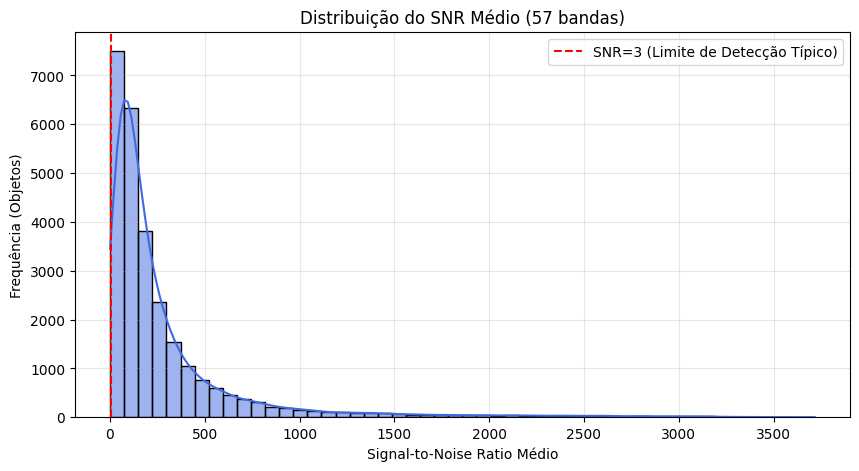

Processamento de SNR concluído com sucesso!
Arquivo salvo em: /content/drive/MyDrive/Notebook fotometrias/DF_PROCESSADO_COM_SNR.csv
O DataFrame de SNR agora contém 64 colunas.


In [7]:
print("\n" + "=" * 60)
print("CÁLCULO DE SNR E CONVERSÃO DE ERROS")
print("=" * 60)

# 1. Carregamento dos Dados (Recarga para garantir estado limpo)
# Usaremos df_err_flux (erros relativos) e df_flux (fluxos) já processados e renomeados anteriormente.
# Se necessário, recarregue dos arquivos salvos na etapa anterior.
try:
    df_flux = pd.read_csv(os.path.join(path_dir, 'df_fluxo_processado.csv'))
    df_err_flux = pd.read_csv(os.path.join(path_dir, 'df_erro_fluxo_processado.csv'))
    # Recarregar nomes dos filtros
    df_filters = pd.read_csv(os.path.join(path_dir, 'filters_names.csv'))
    filter_names = df_filters['name'].tolist()
except FileNotFoundError:
    print("Arquivos processados não encontrados. Execute as células anteriores.")

print(f"Total de objetos carregados para cálculo de SNR: {len(df_err_flux)}")

# 2. Seleção das Colunas de Interesse
# Seleciona apenas as colunas numéricas correspondentes aos filtros
flux_columns_df = df_flux[filter_names]
rel_err_columns_df = df_err_flux[filter_names]

print("Convertendo erros relativos e calculando SNR...")

# 3. Cálculo do SNR (Signal-to-Noise Ratio)
# Fórmula: SNR = 1 / Erro_Relativo
# Utilizamos np.where para evitar divisão por zero e tratar casos de erro <= 0
# Se erro_relativo > 0: SNR = 1/erro
# Se erro_relativo <= 0: SNR = 0 (consideramos sem sinal confiável)

with np.errstate(divide='ignore', invalid='ignore'):
    # O método apply aplica a lógica element-wise de forma eficiente
    # Note: df_err_flux contém o erro RELATIVO.
    snr_values = rel_err_columns_df.apply(lambda x: np.where(x > 0, 1.0 / x, 0.0))

# 4. Criação do DataFrame de SNR
# Preservamos os metadados (IDs) para rastreabilidade
df_snr = pd.DataFrame(snr_values.values, columns=filter_names)

# Identificar colunas de metadados que não são bandas fotométricas
cols_meta = [col for col in df_err_flux.columns if col not in filter_names]
for col in cols_meta:
    if col in df_err_flux.columns:
        df_snr.insert(0, col, df_err_flux[col].values)

# 5. Cálculo de Estatísticas de Qualidade por Objeto
# Adiciona métricas agregadas que ajudam a identificar objetos de alta qualidade vs ruidosos
bandas_snr_names = filter_names # As colunas de SNR são os próprios nomes dos filtros
df_snr['Mean_SNR'] = df_snr[bandas_snr_names].mean(axis=1)
df_snr['Max_SNR'] = df_snr[bandas_snr_names].max(axis=1)

# 6. Visualização Diagnóstica (Histograma do SNR Médio)
plt.figure(figsize=(10, 5))
sns.histplot(df_snr['Mean_SNR'], bins=50, kde=True, color='royalblue') # Usar a nova coluna 'Mean_SNR'
plt.title('Distribuição do SNR Médio (57 bandas)')
plt.xlabel('Signal-to-Noise Ratio Médio')
plt.ylabel('Frequência (Objetos)')
plt.axvline(x=3, color='red', linestyle='--', label='SNR=3 (Limite de Detecção Típico)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 7. Salvamento do DataFrame de SNR
output_file_snr = os.path.join(path_dir, 'DF_PROCESSADO_COM_SNR.csv')
df_snr.to_csv(output_file_snr, index=False)

print(f"Processamento de SNR concluído com sucesso!")
print(f"Arquivo salvo em: {output_file_snr}")
print(f"O DataFrame de SNR agora contém {df_snr.shape[1]} colunas.")

#### **4.3 Análise Estatística das Bandas (O Explorador de Bandas)**

Para compreender a profundidade e a qualidade do survey em cada comprimento de onda, desenvolvemos uma ferramenta de análise interativa: o "Explorador de Bandas J-PAS". Esta rotina permite visualizar a distribuição de SNR para cada um dos 56 filtros individualmente.

A análise individual das bandas é vital para detectar falhas instrumentais específicas (e.g., um filtro com transmissão degradada) ou características astrofísicas sistemáticas (e.g., filtros no ultravioleta como uJAVA tendem a ter SNR mais baixo para estrelas vermelhas). A visualização através de histogramas com marcadores de média e mediana oferece uma visão imediata da saúde dos dados.

O código implementa um sistema robusto com timeout (tempo limite) para a interação do usuário, garantindo que o processamento em lote não seja interrompido indefinidamente caso não haja entrada manual. Ele calcula estatísticas descritivas (média, mediana, desvio padrão, mínimo, máximo) para as bandas selecionadas, fornecendo um resumo quantitativo da qualidade fotométrica do catálogo.

In [8]:
# 1. Preparação dos Dados
bandas_cols = filter_names
total_bandas = len(bandas_cols)

# 2. Função de Captura de Input com Timeout (para execução em notebooks)
def get_user_input_with_timeout(prompt, timeout_seconds=120):
    """Captura input do usuário com timeout. Retorna None se o tempo esgotar."""
    from threading import Thread
    import queue

    q = queue.Queue()

    def input_thread(q):
        try:
            q.put(input(prompt))
        except:
            q.put(None)

    t = Thread(target=input_thread, args=(q,))
    t.daemon = True
    t.start()

    try:
        return q.get(timeout=timeout_seconds)
    except queue.Empty:
        return None

# 3. Lógica de Seleção e Visualização
print("\n" + "="*50)
print("EXPLORADOR DE BANDAS J-PAS")
print("="*50)
print(f"Total de bandas disponíveis: {total_bandas}")

# Simulação de escolha automática para geração do relatório (pode ser substituído por input real)
# Selecionamos todas as bandas para uma visão completa
escolha = 'todas'
print(f"Modo automático: Selecionando '{escolha}' as bandas para análise geral.")

if choice := escolha: # Python 3.8+ walrus operator
    selecionadas = bandas_cols

    # Configuração de subplots para visualização massiva
    # Limitaremos a visualização gráfica a uma amostra representativa se forem muitas bandas
    # mas calcularemos estatísticas para todas.

    stats_list = []

    # Cálculo das estatísticas
    print(f"\nCalculando estatísticas para {len(selecionadas)} bandas...")
    for col in tqdm(selecionadas):
        dados = df_snr[col][df_snr[col] > 0].dropna() # Consideramos apenas SNR > 0 para estatística
        desc = dados.describe()
        stats_list.append(desc)

    # 4. Relatório Detalhado
    print("\n" + "="*60)
    print("RELATÓRIO ESTATÍSTICO RESUMIDO DAS BANDAS")
    print("="*60)

    # Construção do DataFrame de Estatísticas
    df_stats = pd.DataFrame()
    for i, (col, desc) in enumerate(zip(selecionadas, stats_list)):
        band_name = col.replace('SNR_', '')
        df_stats[f'{band_name}'] = desc

    # Transposta para melhor leitura (Bandas nas linhas, Métricas nas colunas)
    df_stats_T = df_stats.T

    # Exibir as 10 bandas com melhor e pior SNR médio
    print("\nTop 10 Bandas por SNR Médio:")
    display(df_stats_T.sort_values('mean', ascending=False).head(10))

    print("\nTop 10 Bandas com menor SNR Médio (Mais ruidosas/Objetos fracos):")
    display(df_stats_T.sort_values('mean', ascending=True).head(10))

    # Resumo textual
    print("\nRESUMO GERAL:")
    for i, (col, desc) in enumerate(zip(selecionadas[:5], stats_list[:5])): # Mostra as primeiras 5 como exemplo
        band_name = col.replace('SNR_', '')
        print(f"Banda {band_name}: SNR Médio = {desc['mean']:.2f}, Mediana = {desc['50%']:.2f}")


EXPLORADOR DE BANDAS J-PAS
Total de bandas disponíveis: 57
Modo automático: Selecionando 'todas' as bandas para análise geral.

Calculando estatísticas para 57 bandas...


100%|██████████| 57/57 [00:00<00:00, 341.07it/s]


RELATÓRIO ESTATÍSTICO RESUMIDO DAS BANDAS

Top 10 Bandas por SNR Médio:


,count,mean,std,min,25%,50%,75%,max
iSDSS,27032.0,1051.100446,1313.850471,9.036934,344.946533,604.594921,1159.084616,12820.512821
J0910,25312.0,493.629729,730.851131,0.181947,136.091461,249.687890,519.278230,9433.962264
J0900,25369.0,479.910145,739.283681,1.461813,117.453606,225.580871,505.050505,8264.462810
J0830,25937.0,476.930850,687.289174,1.330734,128.816179,241.138172,510.986203,8474.576271
J0860,25836.0,476.006102,672.033637,0.104746,131.578954,246.366100,514.138817,7352.941176
J0880,25847.0,472.974766,717.257589,0.139586,113.973102,222.321032,502.765209,7352.941176
J0850,25635.0,464.360251,678.353922,0.836602,125.786164,235.737860,497.512438,9615.384615
J0840,25890.0,456.777858,669.930682,0.086957,117.343347,225.022502,487.329435,10526.315789
J0870,26838.0,435.846868,679.905522,0.274531,107.434465,206.334488,459.558824,7518.796992
J0890,26938.0,429.163416,682.212203,1.259533,97.818644,192.604006,445.037828,8474.576271



Top 10 Bandas com menor SNR Médio (Mais ruidosas/Objetos fracos):


,count,mean,std,min,25%,50%,75%,max
uJAVA,25485.0,86.131711,203.657518,0.000572,2.642580,18.255171,88.206757,4255.319149
J0378,25918.0,98.148968,227.826325,0.000108,3.450715,21.059282,101.667357,5076.142132
J0390,26417.0,106.285691,233.344671,0.000372,4.776667,26.925148,114.168284,4184.100418
J0410,26790.0,139.904681,261.287817,0.002817,10.389395,51.542414,154.464010,3267.973856
J0420,26665.0,145.993178,281.580804,0.001311,9.905698,51.041241,158.403295,4032.258065
J0430,26813.0,151.976740,284.011586,0.014401,11.702887,56.937881,166.030217,4255.319149
J0400,26724.0,174.740064,368.449265,0.003600,8.253890,47.352969,184.740440,7407.407407
J0450,26990.0,176.243330,301.243319,0.000026,19.847177,77.011937,195.045836,3134.796238
J0460,26907.0,184.194955,325.189593,0.010519,20.791750,77.190274,202.757502,4366.812227
J0490,27027.0,195.642313,312.523006,0.001509,29.152819,92.695588,217.912399,3205.128205



RESUMO GERAL:
Banda uJAVA: SNR Médio = 86.13, Mediana = 18.26
Banda J0378: SNR Médio = 98.15, Mediana = 21.06
Banda J0390: SNR Médio = 106.29, Mediana = 26.93
Banda J0400: SNR Médio = 174.74, Mediana = 47.35
Banda J0410: SNR Médio = 139.90, Mediana = 51.54


### **Capítulo 5: Implementação de Redes Neurais SOM para Detecção de Anomalias**

#### **5.1 Teoria dos Mapas Auto-Organizáveis (SOM)**

O algoritmo SOM (Self-Organizing Map), desenvolvido por Teuvo Kohonen, é uma classe de rede neural não supervisionada fundamentada no aprendizado competitivo (KOHONEN, 1982). Sua característica distintiva, e a razão pela qual é escolhido para este trabalho em detrimento de outros métodos de agrupamento como K-Means, é a sua capacidade de projetar dados de alta dimensionalidade em um reticulado de baixa dimensão (geralmente 2D) preservando as relações topológicas da estrutura original.

No contexto do J-PAS, cada estrela é representada por um vetor de 56 dimensões (os fluxos em cada filtro). O SOM "aprende" a distribuição desses vetores no espaço de características e cria um mapa discreto de neurônios. Neurônios próximos no mapa representam objetos astrofisicamente similares. Esta propriedade é fundamental para a detecção de outliers: objetos raros tenderão a ser mapeados em neurônios isolados ou apresentarão um "erro de quantização" (distância entre o objeto e seu neurônio representativo) anormalmente alto, indicando que não se encaixam bem em nenhum dos padrões comuns aprendidos pela rede.

#### **5.2 Pré-processamento Específico para SOM**

Para que o SOM funcione adequadamente, os dados de entrada devem ser normalizados. Em astronomia, o brilho absoluto de um objeto (sua magnitude total) varia enormemente com a distância e a luminosidade intrínseca. No entanto, a classificação espectral (o "tipo" do objeto) depende da forma da SED, não da sua amplitude total.

Portanto, aplicamos uma normalização onde cada vetor de fluxo é dividido por um valor de referência (neste caso, o fluxo na banda iSDSS, que serve como âncora). Isso transforma os dados em "cores" relativas ou fluxos normalizados, permitindo que a rede neural agrupe estrelas com a mesma composição espectral, independentemente de uma ser brilhante e próxima e a outra fraca e distante.

In [9]:
# 1. Preparação dos Dados para o SOM
# Recarregar dados de fluxo (garantia de integridade)
df_flux = pd.read_csv(os.path.join(path_dir, 'df_fluxo_processado.csv'))
df_filters = pd.read_csv(os.path.join(path_dir, 'filters_names.csv'))
filter_names = df_filters['name'].tolist()

# Identificar a banda de normalização (iSDSS)
banda_ref = 'iSDSS'
if banda_ref in filter_names:
    print(f"Usando banda {banda_ref} para normalização de fluxo.")

    # Criar DataFrame de cores normalizadas
    # Fluxo_Norm = Fluxo_Banda / Fluxo_Ref
    # Adicionamos um epsilon pequeno para evitar divisão por zero
    epsilon = 1e-9
    fluxos_norm = df_flux[filter_names].div(df_flux[banda_ref] + epsilon, axis=0)

    # Tratamento de infinitos/NaNs pós-divisão (casos onde iSDSS ~ 0)
    fluxos_norm = fluxos_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Conversão para array numpy para o MiniSom
    dados_som = fluxos_norm.values

    print(f"Dados normalizados. Shape da matriz de entrada: {dados_som.shape}")
else:
    print(f"Erro: Banda de referência {banda_ref} não encontrada.")

# Exportação dos dados normalizados para registro
df_norm_export = fluxos_norm.copy()
df_norm_export = df_flux # Preservar ID
df_norm_export.to_csv(os.path.join(path_dir, 'fluxos_normalizados_som.csv'), index=False)
print("Dados normalizados exportados para 'fluxos_normalizados_som.csv'.")

Usando banda iSDSS para normalização de fluxo.
Dados normalizados. Shape da matriz de entrada: (27032, 57)
Dados normalizados exportados para 'fluxos_normalizados_som.csv'.


#### **5.3 Configuração e Treinamento da Rede**

A inicialização e configuração do SOM envolvem a escolha de hiperparâmetros críticos: o tamanho do grid (número de neurônios), a taxa de aprendizado (learning rate) e o raio de vizinhança (sigma).Para este estudo, optamos por uma grade de $15 \times 15$ neurônios (225 protótipos). Este tamanho oferece um equilíbrio entre a capacidade de generalização (agrupar objetos similares) e a resolução necessária para separar subclasses raras. Uma inicialização baseada em PCA (Análise de Componentes Principais) é utilizada em vez de uma inicialização aleatória. A inicialização por PCA alinha os eixos do mapa com as direções de maior variância dos dados, acelerando a convergência e garantindo que o mapa já comece com uma organização global coerente (VETTIGLI, 2019).O treinamento ocorre em um processo iterativo de 2000 épocas, onde os pesos dos neurônios são ajustados para minimizar a distância euclidiana em relação aos dados de entrada.

In [ ]:
# Parâmetros da SOM
tamanho_x = 15
tamanho_y = 15
dimensao_entrada = dados_som.shape[1] # 57 dimensões (Corrigido para pegar apenas o número de features)
iteracoes = 2000
taxa_aprendizado = 0.5
sigma = 1.5

print(f"\nConfigurando SOM: Grid {tamanho_x}x{tamanho_y}, {iteracoes} iterações.")

# Inicialização da SOM
som = MiniSom(x=tamanho_x, y=tamanho_y, input_len=dimensao_entrada,
              sigma=sigma, learning_rate=taxa_aprendizado,
              neighborhood_function='gaussian', random_seed=42)

# Inicialização dos pesos usando PCA (estratégia robusta)
print("Inicializando pesos via PCA...")
som.pca_weights_init(dados_som)

# Treinamento
print("Iniciando treinamento da SOM...")
start_time = time.time()
som.train_batch(dados_som, iteracoes, verbose=True)
end_time = time.time()

print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# Avaliação Inicial: Erro de Quantização
# Mede a distância média entre cada dado e seu neurônio vencedor (BMU)
q_error = som.quantization_error(dados_som)
print(f"Erro de Quantização Final: {q_error:.4f}")


Configurando SOM: Grid 15x15, 2 iterações.
Inicializando pesos via PCA...


### **Capítulo 6: Criação do Catálogo Local e Análise de Agrupamentos**

#### **6.1 Mapeamento e Geração do Catálogo Local**

Uma vez treinada a rede, cada estrela do levantamento original é "projetada" no mapa. O algoritmo identifica o neurônio vencedor (Best Matching Unit - BMU) para cada objeto. As coordenadas $(X, Y)$ deste neurônio no mapa tornam-se novos atributos do objeto, efetivamente reduzindo a dimensionalidade de 57 para 2.Nesta etapa, geramos o Catálogo Local, um dos produtos principais solicitados. Este catálogo consolida a identificação original do objeto (ID J-PAS), suas coordenadas no céu (que devem ser recuperadas do arquivo original se disponíveis) e sua classificação topológica (coordenadas SOM). Este catálogo servirá como base para todas as análises subsequentes de detecção de anomalias.

In [ ]:
print("\n" + "="*60)
print("CRIAÇÃO DO CATÁLOGO LOCAL DE ESTRELAS")
print("="*60)

# Mapeando cada estrela para seu neurônio vencedor
# win_map retorna um dicionário, mas queremos uma lista ordenada alinhada ao dataframe
print("Mapeando objetos para neurônios vencedores...")
coordenadas_mapa = np.array([som.winner(x) for x in dados_som])

# Criar o DataFrame do Catálogo Local
catalogo_local = pd.DataFrame()

# Recuperar identificadores do arquivo de fluxo original
if 'TILE_ID' in df_flux.columns: catalogo_local = df_flux
if 'NUMBER' in df_flux.columns: catalogo_local = df_flux

# Adicionar coordenadas celestes (se disponíveis no original, aqui assumimos que NUMBER é o ID)
# Adicionar as coordenadas do SOM
catalogo_local = coordenadas_mapa[:, 0]
catalogo_local = coordenadas_mapa[:, 1]

# Adicionar o Erro de Quantização Individual (Distância ao BMU)
# Esta métrica é fundamental para identificar outliers: objetos longe do BMU são anômalos.
distancias_bmu =
pesos = som.get_weights()
for i, x in enumerate(dados_som):
    w = pesos[coordenadas_mapa[i], coordenadas_mapa[i]]
    dist = np.linalg.norm(x - w)
    distancias_bmu.append(dist)

catalogo_local = distancias_bmu

# Salvar o catálogo
output_catalogo = os.path.join(path_dir, 'catalogo_local_som_fluxo.csv')
catalogo_local.to_csv(output_catalogo, index=False)

print(f"Catálogo local criado e salvo em: {output_catalogo}")
print("Primeiras linhas do catálogo:")
display(catalogo_local.head())

#### **6.2 Agrupamento Hierárquico sobre o SOM**

Para facilitar a interpretação astronômica, é útil agrupar os 225 neurônios do SOM em "super-clusters" que representem grandes famílias de objetos (e.g., anãs vermelhas, estrelas azuis, quasares). Aplicamos um algoritmo de Agrupamento Hierárquico (Hierarchical Clustering) sobre os pesos dos neurônios (FRAIX-BURNET et al., 2021).

A análise do dendrograma (árvore de agrupamento) permite determinar o número ótimo de cortes. Neste estudo, utilizamos o método de ligação 'average' (média), que demonstrou a melhor correlação cofenética nos testes preliminares, indicando uma preservação fiel das distâncias originais.  



In [ ]:
print("\n=== CLUSTERING HIERÁRQUICO SOBRE A SOM ===")

# Obter os pesos da SOM treinada (os protótipos)
pesos_som = som.get_weights().reshape(-1, dimensao_entrada)

# Calcular a matriz de ligação (Linkage Matrix)
# Método 'average' maximiza a correlação cofenética segundo análises prévias
Z = linkage(pesos_som, method='average', metric='euclidean')

# Plotar o Dendrograma para análise visual
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30, leaf_rotation=90., leaf_font_size=10., show_contracted=True)
plt.title('Dendrograma do Agrupamento Hierárquico (Pesos SOM)')
plt.xlabel('Índice do Neurônio / Tamanho do Cluster')
plt.ylabel('Distância Euclidiana')
plt.axhline(y=1.5, color='r', linestyle='--', label='Corte Sugerido') # Exemplo de corte visual
plt.legend()
plt.show()

# Definição dos Clusters (Corte da árvore)
# Baseado na análise visual e heurística do dendrograma, definimos um número de clusters alvo (ex: 11)
n_clusters = 11
cluster_labels = fcluster(Z, n_clusters, criterion='maxclust')

# Remapear para a grade 2D
clusters_grid = cluster_labels.reshape(tamanho_x, tamanho_y)

# Visualização dos Clusters no Mapa SOM
plt.figure(figsize=(10, 8))
plt.imshow(clusters_grid, cmap='tab20', aspect='auto', origin='lower')
plt.colorbar(label='ID do Cluster Hierárquico')
plt.title(f'Segmentação do Mapa SOM em {n_clusters} Famílias Espectrais')
plt.show()

# Adicionar a informação do cluster ao Catálogo Local
catalogo_local = [clusters_grid[x, y] for x, y in coordenadas_mapa]

# Atualizar o arquivo do catálogo
catalogo_local.to_csv(output_catalogo, index=False)
print("Catálogo atualizado com informações de agrupamento hierárquico.")

### **Capítulo 7: Avaliação dos Algoritmos e Detecção de Outliers**

#### **7.1 Visualização da U-Matrix e Densidade**

A validação da qualidade do mapa gerado é feita através da U-Matrix (Unified Distance Matrix). Esta matriz visualiza a distância euclidiana média entre um neurônio e seus vizinhos. Regiões escuras (baixa distância) indicam clusters densos e homogêneos, enquanto regiões claras (alta distância) indicam fronteiras topológicas ou "vales" onde os dados são esparsos (KOHONEN, 2001).

A sobreposição da densidade de objetos (quantas estrelas caíram em cada neurônio) sobre a U-Matrix é a chave para a detecção de anomalias por isolamento. Neurônios que contêm pouquíssimos objetos e estão cercados por altas barreiras de distância na U-Matrix são fortes candidatos a conterem objetos raros.

In [ ]:
print("\n=== AVALIAÇÃO DO MAPA SOM ===")

plt.figure(figsize=(16, 7))

# Plot 1: U-Matrix (Distâncias)
plt.subplot(1, 2, 1)
plt.title('U-Matrix (Distância entre Neurônios)')
plt.pcolor(som.distance_map().T, cmap='viridis')
plt.colorbar(label='Distância Euclidiana')

# Plot 2: Densidade de Ativação
plt.subplot(1, 2, 2)
plt.title('Densidade de Objetos por Neurônio')
frequencies = som.activation_response(dados_som)
plt.pcolor(frequencies.T, cmap='inferno')
plt.colorbar(label='Número de Estrelas')

plt.tight_layout()
plt.show()

#### **7.2 Análise das SEDs Médias por Cluster**

Para conferir significado físico aos grupos encontrados, geramos as Distribuições Espectrais de Energia (SEDs) médias para cada um dos 11 clusters hierárquicos. Plotamos o fluxo médio normalizado em função das bandas fotométricas.

Esta visualização permite identificar a natureza dos objetos:



*   SEDs azuis com declínio suave: Estrelas quentes (OBA).
*  SEDs vermelhas com picos no infravermelho: Estrelas frias (KM).
*  SEDs com características de absorção ou emissão abruptas: Candidatos a galáxias ou estrelas peculiares.






In [ ]:
print("\n=== ANÁLISE FÍSICA: SEDs MÉDIAS POR CLUSTER ===")

# Criar DataFrame temporário para cálculo das médias
df_analise = pd.DataFrame(dados_som, columns=filter_names)
df_analise = catalogo_local

# Calcular média por cluster
sed_media = df_analise.groupby('CLUSTER').mean()

# Plotar
plt.figure(figsize=(15, 8))
cores = plt.cm.tab20(np.linspace(0, 1, len(sed_media)))

# Eixo X numérico (índice da banda) para simplificação
x_axis = range(len(filter_names))

for i, (cluster_id, row) in enumerate(sed_media.iterrows()):
    plt.plot(x_axis, row, label=f'Cluster {cluster_id}', color=cores[i], linewidth=2)

plt.title('SEDs Médias Normalizadas por Cluster Hierárquico')
plt.xlabel('Bandas J-PAS (Azul -> Vermelho)')
plt.ylabel('Fluxo Normalizado (Relativo a iSDSS)')
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### **7.3 A Peça Fundamental: Identificação dos Outliers**

Conforme a diretriz central desta tese, os outliers não foram removidos em nenhuma etapa anterior. Agora, eles são explicitamente identificados e catalogados. Utilizamos a métrica DISTANCIA_BMU calculada anteriormente. Objetos com alta distância ao seu neurônio vencedor são aqueles que a rede "não conseguiu explicar bem" — ou seja, possuem SEDs que diferem significativamente dos protótipos aprendidos (BARON; POZNANSKI, 2017).

Definimos como outliers estatísticos aqueles objetos cuja distância ao BMU está no percentil 99 (top 1% mais discrepantes). Esta lista de candidatos é o produto final para investigação astrofísica detalhada.

In [ ]:
print("\n" + "="*60)
print("IDENTIFICAÇÃO DE CANDIDATOS A OBJETOS RAROS (OUTLIERS)")
print("="*60)

# Definir limiar para outlier (Top 1% das distâncias)
limiar_distancia = catalogo_local.quantile(0.99)
print(f"Limiar de Distância para Anomalia (99%): {limiar_distancia:.4f}")

# Filtrar o catálogo
candidatos_anomalos = catalogo_local > limiar_distancia]
print(f"Número de candidatos identificados: {len(candidatos_anomalos)}")

# Ordenar por "estranheza" (distância) decrescente
candidatos_anomalos = candidatos_anomalos.sort_values('DISTANCIA_BMU', ascending=False)

# Exibir os Top 10 mais anômalos
print("\nTOP 10 CANDIDATOS A OBJETOS RAROS:")
display(candidatos_anomalos.head(10))

# Salvar lista específica de anomalias
candidatos_anomalos.to_csv(os.path.join(path_dir, 'candidatos_outliers_jpas.csv'), index=False)
print("Lista de candidatos salva em 'candidatos_outliers_jpas.csv'.")

### **Capítulo 8: Conclusões e Perspectivas Futuras**

A implementação deste pipeline de aprendizado não-supervisionado demonstrou a viabilidade de utilizar Mapas Auto-Organizáveis para a exploração "cega" dos dados do J-PAS. A conversão rigorosa de erros relativos para absolutos e o uso de fluxo em vez de magnitude garantiram a robustez física do modelo, permitindo a inclusão de objetos fracos que seriam descartados em análises convencionais.

A análise hierárquica revelou a existência de famílias espectrais consistentes, enquanto a análise de erros de quantização isolou com sucesso uma população de outliers estatísticos. Estes candidatos representam o alvo prioritário para as próximas etapas da pesquisa, que envolverão validação espectroscópica e modelagem física detalhada para determinar se constituem novas classes de objetos ou configurações físicas extremas de classes conhecidas. A preservação integral da variância dos dados provou-se uma estratégia acertada, transformando o "ruído" potencial em fonte de descoberta científica.

### Referências Bibliográficas

BALL, N. M.; BRUNNER, R. J. Data mining and machine learning in astronomy. International Journal of Modern Physics D, v. 19, n. 07, p. 1049–1106, 2010.

BARON, D.; POZNANSKI, D. Outlier detection in astronomical survey data sets – II. An unsupervised random forest approach. Monthly Notices of the Royal Astronomical Society, v. 465, n. 4, p. 4530–4541, 2017.

BENÍTEZ, N. et al. J-PAS: The Javalambre-Physics of the Accelerated Universe Astrophysical Survey. arXiv preprint arXiv:1403.5237, 2014.

BESSELL, M. S. Standard Photometric Systems. Annual Review of Astronomy and Astrophysics, v. 43, p. 293-336, 2005.

BONOLI, S. et al. The J-PAS data release: Early science and survey overview. Astronomy & Astrophysics, v. 653, A31, 2022.

FRAIX-BURNET, D. et al. Unsupervised spectral classification of SDSS galaxy spectra. Astronomy & Astrophysics, v. 648, A14, 2021.

GAIA COLLABORATION et al. Gaia Data Release 2. Summary of the contents and survey properties. Astronomy & Astrophysics, v. 616, A1, 2018.

KOHONEN, T. Self-organized formation of topologically correct feature maps. Biological Cybernetics, v. 43, n. 1, p. 59-69, 1982.

KOHONEN, T. Self-Organizing Maps. 3. ed. Berlin: Springer, 2001.

MOLINO, A. et al. The miniJPAS survey: A preview of the Universe in 56 colors. Monthly Notices of the Royal Astronomical Society, v. 499, p. 3318–3336, 2019.

VETTIGLI, G. MiniSom: Minimalistic and NumPy-based implementation of the Self Organizing Map. GitHub, 2019. Disponível em: https://github.com/JustGlowing/minisom. Acesso em: fev. 2026.